<a href="https://colab.research.google.com/github/mhyamt/VGG16-CXR-COVID19-Classification/blob/main/transfer_learning_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import gc
import cv2
import math
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download tawsifurrahman/covid19-radiography-database

 97% 753M/778M [00:03<00:00, 306MB/s]
100% 778M/778M [00:03<00:00, 255MB/s]


In [ ]:
!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
PATH_TO_METADATA = "COVID-19_Radiography_Dataset/Normal.metadata.xlsx"
df = pd.read_excel(PATH_TO_METADATA)
df.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)

In [ ]:
!ls /tmp

dap_multiplexer.050c322c3886.root.log.INFO.20220710-072314.59
dap_multiplexer.INFO
debugger_10se4aeh56
initgoogle_syslog_dir.0
pyright-113-FyG7nBS9sOPz
pyright-113-VVMRZVwX05RI
python-languageserver-cancellation


In [ ]:
!mkdir /tmp/Xray_train_data

In [ ]:
!cp -R "COVID-19_Radiography_Dataset/COVID/images" "/tmp/Xray_train_data/"

In [ ]:
!mv "/tmp/Xray_train_data/images" "/tmp/Xray_train_data/COVID"

In [ ]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [ ]:
!mkdir "/tmp/Xray_train_data/NORMAL"

In [ ]:
import os
import shutil
cnt = 0
for (i, row) in df.iterrows():
    if (cnt < 3616):
        filename = row["FILE NAME"].lower().capitalize() + "." + row["FORMAT"].lower()
        image_path = os.path.join("COVID-19_Radiography_Dataset/Normal/images", filename)
        image_copy_path = os.path.join("/tmp/Xray_train_data/NORMAL", filename)
        shutil.copy2(image_path, image_copy_path)
        cnt += 1

print(cnt)

3616


In [ ]:
!ls "/tmp/Xray_train_data"

COVID  NORMAL


In [ ]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [ ]:
!ls -1 "/tmp/Xray_train_data/NORMAL"| wc -l

3616


In [ ]:
train_data_dir= "/tmp/Xray_train_data"


In [ ]:
Train_Valid_gen=ImageDataGenerator(rescale=(1./255) , rotation_range=180, width_shift_range=0.2,
                        height_shift_range=0.2, horizontal_flip=True, validation_split=0.1)

In [ ]:
train_gen= Train_Valid_gen.flow_from_directory(directory = train_data_dir, target_size=img_size, subset='training',
                                               batch_size=batch_size,  class_mode='categorical', shuffle = True, seed=58)

Found 6510 images belonging to 2 classes.


In [ ]:
Valid_gen= Train_Valid_gen.flow_from_directory(directory = train_data_dir, target_size=img_size, subset='validation',
                                               batch_size=batch_size,  class_mode='categorical', shuffle = True, seed=12)


Found 722 images belonging to 2 classes.


# Data

In [ ]:
print(Valid_gen.class_indices)
print(train_gen.class_indices)
classes = Valid_gen.class_indices

{'COVID': 0, 'NORMAL': 1}
{'COVID': 0, 'NORMAL': 1}


In [ ]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(Valid_gen)

In [ ]:
print(type(train_images[0]))

<class 'numpy.ndarray'>


In [ ]:
print("Train Images shape " , train_images.shape)
print("Valid Images shape " , train_images.shape)

Train Images shape  (32, 224, 224, 3)
Valid Images shape  (32, 224, 224, 3)


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers.merge import concatenate
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Conv2D,Input,GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

In [ ]:
def build_model():
    # use imagenet - pre-trainined weights for images
    baseModel = VGG16(weights= 'imagenet', include_top = False, input_shape=(img_shape))

    for layer in baseModel.layers[:-3]:
      layer.trainable = False

    headModel = baseModel.output
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = BatchNormalization()(headModel)

    headModel = Dense(128, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)

    headModel = Dense(2, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    optimizers = RMSprop(learning_rate=0.00001)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers, metrics = ['accuracy'])

    return model
model=build_model()
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from keras.callbacks import ModelCheckpoint
import datetime
import keras


checkpoint_filepath = '/tmp/checkpoint'
callbacks = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,   save_weights_only=True,
                           monitor='val_loss',    mode='min',   save_best_only=True,   verbose=3)
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)



cnnModel=model.fit( train_gen, validation_data=Valid_gen, epochs=20,  verbose=1, callbacks=[callbacks, callback1])

Epoch 1/20
204/204 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7458
Epoch 1: val_loss improved from inf to 0.61647, saving model to /tmp/checkpoint
204/204 [==============================] - 118s 500ms/step - loss: 0.5618 - accuracy: 0.7458 - val_loss: 0.6165 - val_accuracy: 0.5817
Epoch 2/20
204/204 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.8134
Epoch 2: val_loss improved from 0.61647 to 0.25571, saving model to /tmp/checkpoint
204/204 [==============================] - 99s 484ms/step - loss: 0.4117 - accuracy: 0.8134 - val_loss: 0.2557 - val_accuracy: 0.9100
Epoch 3/20
204/204 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.8327
Epoch 3: val_loss improved from 0.25571 to 0.17157, saving model to /tmp/checkpoint
204/204 [==============================] - 100s 489ms/step - loss: 0.3725 - accuracy: 0.8327 - val_loss: 0.1716 - val_accuracy: 0.9404
Epoch 4/20
204/204 [==============================] - ETA: 0

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_figheight(8)
  fig.set_figwidth(15)
  fig.suptitle('accuracy and loss of model')
  ax1.plot(history.history["loss"],label="loss")
  ax1.plot(history.history["val_loss"],label="val_loss")
  ax2.plot(history.history["accuracy"],label="train")
  ax2.plot(history.history["val_accuracy"],label="validation")
  plt.legend()

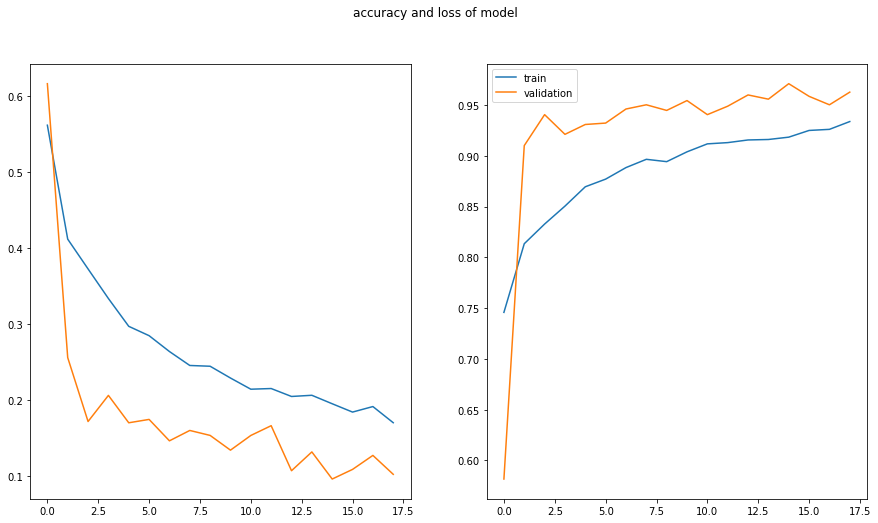

In [ ]:
plot_acc_loss(cnnModel)

In [ ]:
def prediction(img, model, classes):
  pred = model.predict(img)
  pred_class = np.argmax(pred)
  classes_name = list(classes.keys())
  print(classes_name[pred_class])

In [ ]:
def preprocess(img):
  image = img.resize((224,224))
  image = np.asarray(image, dtype=np.float32) / 255
  image = np.expand_dims(image,axis=0)
  return(image)

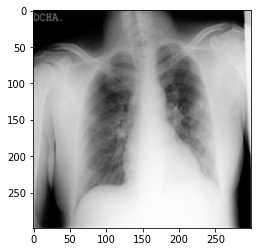

In [ ]:
img_path ='/content/COVID-2.jpg'
plt.figure()
img = Image.open(img_path)
imgplot = plt.imshow(img)

In [ ]:
image = preprocess(img)
prediction(image, model, classes)

COVID


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


In [ ]:
image = preprocess(img)
prediction(image, loaded_model, classes)

COVID
